In [34]:
import numpy as np 
import pandas as pd
from tensorflow.keras.datasets import mnist

In [35]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print("train dataset shape:", train_images.shape, train_labels.shape)
print("test dataset shape:", test_images.shape, test_labels.shape)

train dataset shape: (60000, 28, 28) (60000,)
test dataset shape: (10000, 28, 28) (10000,)


### MNIST image 시각화

Text(0.5, 1.0, '5')

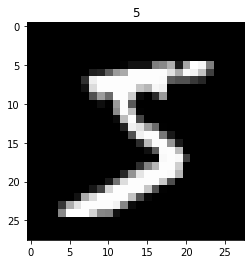

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(train_images[0], cmap='gray') 
plt.title(train_labels[0])

In [37]:
train_images[0, :, :], train_labels[0]
# 0번쨰 이미지 출력

(array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
          18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
           0

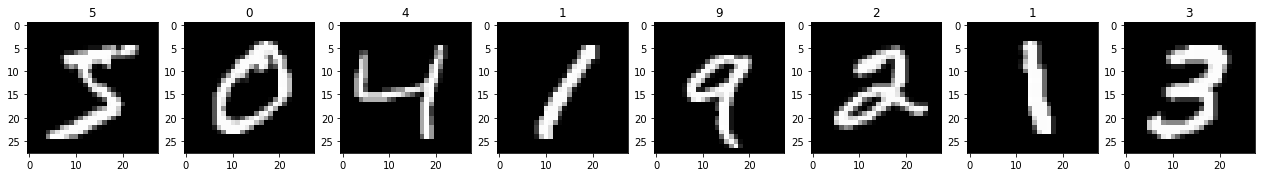

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline 

class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

def show_images(images, labels, ncols=8):
    figure, axs = plt.subplots(figsize=(22, 6), nrows=1, ncols=ncols) 
    for i in range(ncols):
        axs[i].imshow(images[i], cmap='gray') 
        axs[i].set_title(class_names[labels[i]])
        
show_images(train_images[:8], train_labels[:8], ncols=8)

### 데이터 전처리

In [39]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# 0 ~ 1사이의 float32 값으로 변경하는 함수
def get_preprocessed_data(images, labels):
    images = np.array(images/255.0, dtype=np.float32)
    labels = np.array(labels, dtype=np.float32)
    return images, labels

# 0 ~ 사이의 값으로 변경한 함수를 호출한 뒤에 원핫인코딩 적용
def get_preprocessed_ohe(images, labels):
    images, labels = get_preprocessed_data(images, labels)
    oh_labels = to_categorical(labels)
    return images, oh_labels

# 학습/검증/테스트 데이터 세트에 전처리 및 원핫인코딩 적용한 뒤 반환
def get_train_valid_test_set(train_images, train_labels, test_images, test_labels, valid_size=0.2, random_state=2022):
    train_images, train_oh_labels = get_preprocessed_ohe(train_images, train_labels)
    test_images, test_oh_labels = get_preprocessed_ohe(test_images, test_labels)
    tr_images, val_images, tr_oh_labels, val_oh_labels = train_test_split(train_images, train_oh_labels, test_size=valid_size, random_state=random_state)
    
    return (tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels)
    

In [40]:
(tr_images, tr_oh_labels), (val_images, val_oh_labels), (test_images, test_oh_labels) = \
  get_train_valid_test_set(train_images, train_labels, test_images, test_labels)

print(tr_images.shape, tr_oh_labels.shape, val_images.shape, val_oh_labels.shape, test_images.shape, test_oh_labels.shape)

(48000, 28, 28) (48000, 10) (12000, 28, 28) (12000, 10) (10000, 28, 28) (10000, 10)


### 간단한 모델 생성

In [41]:
from tensorflow.keras.layers import Layer, Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf

INPUT_SIZE = 28
# input 이라는 값이 들어온다는 건 => 1장의 이미지에 대한 shape만 만들어주면댐(중요)
# 6만장에 대한 배치는 케라스 프레임웤에서 알아서 결정 -> 2차원으로 1장의 이미지에 대한 입력만 주면 케라스 내부에선 3차원으로 인식함

# 실제 input 여러장, 즉 여기서는 6만개가 학습이 진행 되어 (60000, 28, 28) 이렇게 input을 설정해야 할 것 같지만 아님

# 입력을 받아 모델에서 돌아가는 것은 전부 tensor 
def create_model():
    
    input_tensor = Input(shape=(INPUT_SIZE, INPUT_SIZE)) 
    # 반드시 인풋은 따로 초기화해주기
    x = Flatten()(input_tensor)
    x = Dense(100, activation='relu')(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(70, activation='relu')(x)
    x = Dropout(rate=0.2)(x)
    x = Dense(50, activation='relu')(x)
    output = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=output) 
    # inputs 에서 s는 왜 붙었을까? 
    # 입력값이 하나의 데이터셋만이 아닐 수 있음(이미지, 텍스트, 다른 정형데이터 등등) 여러 종류의 데이터를 받을 수 있음
    
    return model
    
model = create_model()
model.summary()

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 100)               78500     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_15 (Dense)            (None, 70)                7070      
                                                                 
 dropout_5 (Dropout)         (None, 70)                0         
                                                                 
 dense_16 (Dense)            (None, 50)                3550

# 학습 수행

In [43]:
history = model.fit(x=tr_images, y=tr_oh_labels, batch_size=32, epochs=10, validation_data=(val_images, val_oh_labels) )

Epoch 1/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1352 - accuracy: 0.9583 - val_loss: 0.1061 - val_accuracy: 0.9676
Epoch 2/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1250 - accuracy: 0.9622 - val_loss: 0.1014 - val_accuracy: 0.9702
Epoch 3/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.1184 - accuracy: 0.9640 - val_loss: 0.1113 - val_accuracy: 0.9658
Epoch 4/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1095 - accuracy: 0.9669 - val_loss: 0.0931 - val_accuracy: 0.9723
Epoch 5/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1053 - accuracy: 0.9678 - val_loss: 0.1048 - val_accuracy: 0.9697
Epoch 6/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1025 - accuracy: 0.9688 - val_loss: 0.0961 - val_accuracy: 0.9723
Epoch 7/10
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1013 - accuracy: 0.9692 - val_loss: 0.0883 - val_accuracy:

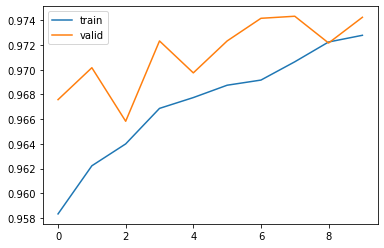

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_history(history):
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()

show_history(history)

### 테스트 데이터로 모델 성능 검증

In [45]:
model.evaluate(test_images, test_oh_labels, batch_size=256, verbose=1)

40/40 [==============================] - 0s 5ms/step - loss: 0.0869 - accuracy: 0.9764


[0.0868622288107872, 0.9764000177383423]